In [1]:
import torch
import torch.nn as nn
import tqdm.notebook as tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9
from warnings import warn
from networks import FractalNet, FractalNetSeparated, Net, GNN_no_rel, GNN
from subgraph import Graph_to_Subgraph

/home/tin/miniconda3/envs/Geometric/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
LABEL_INDEX = 7
def get_qm9(data_dir, device="cuda", transform=None):
    """Download the QM9 dataset from pytorch geometric. Put it onto the device. Split it up into train / validation / test.
    Args:
        data_dir: the directory to store the data.
        device: put the data onto this device.
    Returns:
        train dataset, validation dataset, test dataset.
    """
    dataset = QM9(data_dir, transform=transform)

    # Permute the dataset
    try:
        permu = torch.load("permute.pt")
        dataset = dataset[permu]
    except FileNotFoundError:
        warn("Using non-standard permutation since permute.pt does not exist.")
        dataset, _ = dataset.shuffle(return_perm=True)

    # z score / standard score targets to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, LABEL_INDEX].item(), std[:, LABEL_INDEX].item()

    # Move the data to the device (it should fit on lisa gpus)
    dataset.data = dataset.data.to(device)

    len_train = 100_000
    len_val = 10_000

    train = dataset[:len_train]
    valid = dataset[len_train : len_train + len_val]
    test = dataset[len_train + len_val :]

    assert len(dataset) == len(train) + len(valid) + len(test)

    return train, valid, test

In [11]:
node_features = 5
Z_ONE_HOT_DIM = 5
EDGE_ATTR_DIM = 4
edge_features = 0
hidden_features = 64
out_features = 1

# TRAINING SHARED PARAMETERS FRACTAL NET

In [30]:
# create a fractal net and train it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FractalNet(node_features, edge_features, hidden_features, out_features, depth=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# create a dataloader for qm9
dataset , _ ,_  = get_qm9("data/qm9", device=device, transform=Graph_to_Subgraph())
# take a subset of the dataset
dataset = dataset[:1000]
loader = DataLoader(dataset, batch_size=16, shuffle=True)

<ipython-input-13-c046cd7422f8>:17: UserWarning: Using non-standard permutation since permute.pt does not exist.
  warn("Using non-standard permutation since permute.pt does not exist.")


In [31]:
# get number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 74945


In [ ]:
model.train()
for epoch in range(10):
    avg_loss = 0
    for data in tqdm.tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        target = data.y[:, LABEL_INDEX]
        data.batch = data.batch[data.ground_node]
        out = model(data.x[:, :Z_ONE_HOT_DIM], data.edge_index, data.subgraph_edge_index, data.node_subnode_index, data.subnode_node_index,data.ground_node, data.subgraph_batch_index, data.batch)
        loss = criterion(out.squeeze(), target)
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
        # show loss on tqdm
        #tqdm.tqdm.write(f'Epoch: {epoch}, Loss: {loss.item()}')
    print(f'Epoch: {epoch}, Loss: {avg_loss/len(loader)}')

## TRAINING A UNROLLED FRACTAL NET

In [4]:
# create a fractal net and train it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FractalNetSeparated(node_features, edge_features, hidden_features, out_features, depth=2, pool='add').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# create a dataloader for qm9
dataset , _ ,_  = get_qm9("data/qm9", device=device, transform=Graph_to_Subgraph())
# take a subset of the dataset
#dataset = dataset[:4000]
loader = DataLoader(dataset, batch_size=32, shuffle=True)

<ipython-input-2-c046cd7422f8>:17: UserWarning: Using non-standard permutation since permute.pt does not exist.
  warn("Using non-standard permutation since permute.pt does not exist.")


In [5]:
# get total number of parameters of the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 99777


In [6]:
model.train()
# store loss per epoch
losses = []
for epoch in range(15):
    avg_loss = 0
    for data in tqdm.tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        target = data.y[:, LABEL_INDEX]
        # keep only ground nodes in the data.batch
        data.batch = data.batch[data.ground_node]
        out = model(data.x[:, :Z_ONE_HOT_DIM], data.edge_index, data.subgraph_edge_index, data.node_subnode_index, data.subnode_node_index,data.ground_node, data.subgraph_batch_index, data.batch)
        #print("data batch shape", data.batch.shape)
        #print('data x shape', data.x.shape)
        loss = criterion(out.squeeze(), target)
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
        # show loss on tqdm
        #tqdm.tqdm.write(f'Epoch: {epoch}, Loss: {loss.item()}')
    # store loss per epoch
    losses.append(avg_loss/len(loader))
    print(f'Epoch: {epoch}, Loss: {avg_loss/len(loader)}')

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.07022647024320904


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.011124498769359198


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.007151352456605527


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.008781727792157325


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.006372244659881107


  0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

# TRAINING A NORMAL GNN NET

In [25]:
# create a fractal net and train it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN_no_rel(5, edge_features, hidden_features, out_features, num_convolution_blocks=1, pooling='add').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# create a dataloader for qm9
dataset , _ ,_  = get_qm9("data/qm9", device=device, transform=None)
# take a subset of the dataset
#dataset = dataset[:4000]
loader = DataLoader(dataset, batch_size=32, shuffle=True)

<ipython-input-2-c046cd7422f8>:17: UserWarning: Using non-standard permutation since permute.pt does not exist.
  warn("Using non-standard permutation since permute.pt does not exist.")


In [26]:
# get total number of parameters of the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 95425


In [27]:
model.train()
# store loss per epoch
losses_normal = []
for epoch in range(15):
    avg_loss = 0
    for data in tqdm.tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        target = data.y[:, LABEL_INDEX]
        out = model(data.x[:, :Z_ONE_HOT_DIM], data.edge_index, None, data.batch)
        loss = criterion(out.squeeze(), target)
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
        # show loss on tqdm
        #tqdm.tqdm.write(f'Epoch: {epoch}, Loss: {loss.item()}')
    # store loss per epoch
    losses_normal.append(avg_loss/len(loader))
    print(f'Epoch: {epoch}, Loss: {avg_loss/len(loader)}')

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.33364351208627224


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.15404112273551523


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.012783157381860073


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.03530615497490857


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.0012045859728724462


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.004043459220538498


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.0010818265283970686


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.005676000432023065


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.0006994951154408045


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.0017020229818196094


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.0002780841863833939


  0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

# TRAINING A GNN WITH EDGE FEATURES

In [13]:
# create a fractal net and train it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(n_node_features = Z_ONE_HOT_DIM,
            n_edge_features=EDGE_ATTR_DIM,
            n_hidden=64,
            n_output=out_features,
            num_convolution_blocks=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
# create a dataloader for qm9
dataset , _ ,_  = get_qm9("data/qm9", device=device, transform=None)
# take a subset of the dataset
#dataset = dataset[:4000]
loader = DataLoader(dataset, batch_size=32, shuffle=True)

<ipython-input-2-c046cd7422f8>:17: UserWarning: Using non-standard permutation since permute.pt does not exist.
  warn("Using non-standard permutation since permute.pt does not exist.")


In [14]:
# get total number of parameters of the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 227329


In [15]:
model.train()
# store loss per epoch
losses_GNN = []
for epoch in range(15):
    avg_loss = 0
    for data in tqdm.tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        target = data.y[:, LABEL_INDEX]
        out = model(data.x[:, :Z_ONE_HOT_DIM],
                    data.edge_index,
                    data.edge_attr.argmax(dim=-1),
                    data.batch)
        loss = criterion(out.squeeze(), target)
        loss.backward()
        avg_loss += loss.item()
        optimizer.step()
        # show loss on tqdm
        #tqdm.tqdm.write(f'Epoch: {epoch}, Loss: {loss.item()}')
    # store loss per epoch
    losses_GNN.append(avg_loss/len(loader))
    print(f'Epoch: {epoch}, Loss: {avg_loss/len(loader)}')

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.3061354568508267


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.0454694307699427


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.0038936028466082643


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.0016942769378982484


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.0018182105604896788


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.0014779591096381773


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.0010824688581630472


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.0010484784147159372


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.0007180327489318734


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.0006241234382942639


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.002102256840667978


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.0003417160113131104


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.0005278131626117466


  0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [127]:
### PLOTTING LOSS ###

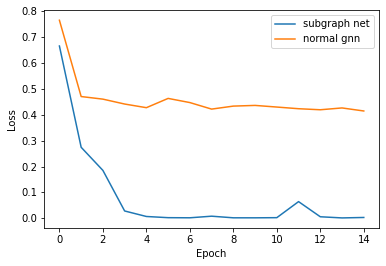

In [128]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(losses, label="subgraph net")
plt.plot(losses_normal, label="normal gnn")
# add axis labels
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()